In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
with open('td_pred.csv', 'rb') as f:
    data = pd.read_csv(f)
    
seleted_data = data.drop(columns=['Year', 'Tourism_Numbers', 'Street_Services', 'Wastewater', 'Public_Transit', 'Parks_and_Recreation', 'Docks', 'Ports'])

In [37]:
# 2. 数据归一化
def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

normalized_data = normalize(seleted_data)


In [38]:
# 3. 计算熵值
def calculate_entropy(df):
    # 转化为概率矩阵
    P = df / df.sum(axis=0)
    
    # 计算信息熵
    k = 1 / np.log(len(df))
    entropy = -k * (P * np.log(P + 1e-12)).sum(axis=0)
    return entropy

entropy = calculate_entropy(normalized_data)

In [39]:
# 4. 根据熵值计算权重
redundancy = 1 - entropy
weights = redundancy / redundancy.sum()

In [40]:
# 输出权重
print(weights)

print('-'*30)
print("weights.sum() == 1 ?")

print(weights.sum() == 1)

stsfy                                     0.048463
Crowding_at_Mendenhall_Glacier            0.073418
Crowding_on_sidewalks_downtown            0.073418
Vehicle_congestion_downtown               0.073418
Flightseeing_noise                        0.048463
Air_emissions_from_cruise_ships           0.048463
Vehicle_congestion_outside_of_downtown    0.073418
Whale_watching_boat_traffic_and_wakes     0.073418
Crowding_on_trails                        0.073418
JNU_Composite                             0.048463
Grocery_Items                             0.048463
JNU_Housing                               0.048463
Utilities                                 0.073418
Transportation                            0.073418
Healthcare                                0.048463
Misc._Good_and_Services                   0.073418
dtype: float64
------------------------------
weights.sum() == 1 ?
True


In [41]:
# 保存权重
weights.to_csv('weights.csv', index=False)

计算所有年份的得分  

    Year     Score
0   2014  0.339242
1   2015  0.346212
2   2016  0.356351
3   2017  0.374410
4   2018  0.399439
5   2019  0.448546
6   2020  0.433867
7   2021  0.419187
8   2022  0.404508
9   2023  0.563870
10  2024  0.573697
11  2025  0.596749
12  2026  0.618250
13  2027  0.639631
14  2028  0.660758


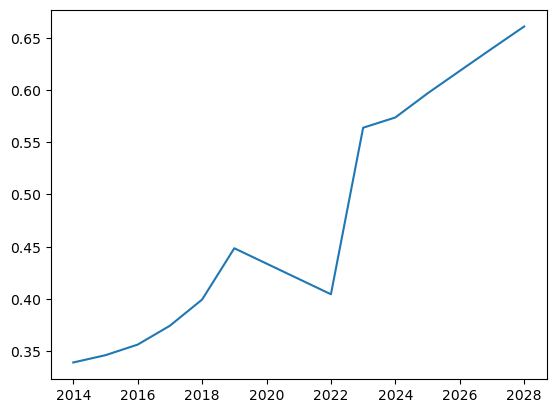

In [42]:
# 计算每一年的得分
scores = normalized_data.dot(weights)

# 将得分添加到原始数据中
data['Score'] = scores

# 输出包含得分的数据
print(data[['Year', 'Score']])

plt.plot(data['Year'], data['Score'])